In [177]:
import torch
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [178]:
NUM_CLASSES = 4
NUM_FEATRUES = 2
RANDOM_SEED = 42

X_blob, y_blob= make_blobs(
    n_samples = 1000,
    n_features = NUM_FEATRUES,
    centers = NUM_CLASSES,
    cluster_std = 1.75,
    random_state = RANDOM_SEED
)

In [179]:
X_blob.shape , y_blob.shape

((1000, 2), (1000,))

In [180]:
X_train , X_test , y_train, y_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [181]:
X_train = torch.tensor(X_train).type(torch.float)
X_test = torch.tensor(X_test).type(torch.float)
y_train = torch.tensor(y_train).type(torch.LongTensor)
y_test = torch.tensor(y_test).type(torch.LongTensor)

In [182]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape


(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

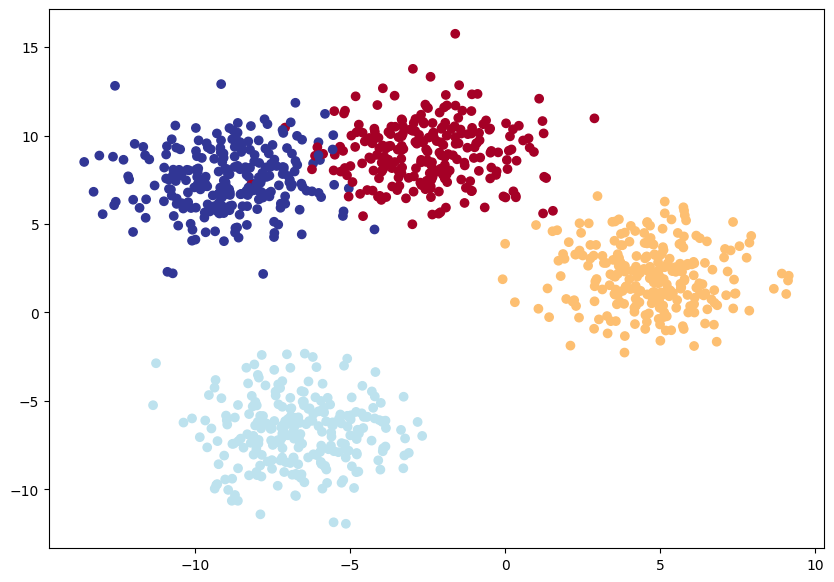

In [183]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [184]:
device = "cuda"  if torch.cuda.is_available() else "cpu"
device

'cuda'

In [185]:
from torch import nn

In [186]:
class BlobModel(nn.Module):
  def __init__(self,input_feature,output_feature,hidden_feature):
    super().__init__()
    '''self.layer_1 = nn.Linear(in_features=2,out_features = 4)
    self.layer_2  = nn.Linear(in_features=4 , out_features = 4)
    self.layer_3 = nn.Linear(in_features=4 , out_features = 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()'''
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_feature,out_features = hidden_feature),
        nn.ReLU(),
        nn.Linear(in_features=hidden_feature , out_features = hidden_feature),
        nn.ReLU(),
        nn.Linear(in_features=hidden_feature , out_features = output_feature),
    )

  def forward(self,x):
    #return self.sigmoid(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))
    return self.linear_layer_stack(x)

model_1 = BlobModel(input_feature=2,
                    output_feature=4,
                    hidden_feature=8).to(device)
model_1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [187]:
device

'cuda'

In [188]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters() , lr = 0.1 )

In [189]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [190]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test.to(device))
y_logits[:5]



tensor([[-0.7928, -0.7809, -1.6323, -1.1677],
        [-0.0937, -0.9350, -0.5888, -0.1355],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.3803, -0.5058, -0.8750, -0.6597],
        [-0.3329, -1.4166, -1.2565, -0.4058]], device='cuda:0')

In [191]:
y_test[:5]

tensor([1, 3, 2, 1, 0])

## In order to train and test the mode;, we need to convert the passing data into probabilities and then to predicting labels

logits -> pred probs ->  pred labels

In [192]:
y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_pred_probs[:5])
print(y_logits[:5])

tensor([[0.3194, 0.3232, 0.1379, 0.2195],
        [0.3334, 0.1437, 0.2032, 0.3197],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3079, 0.2716, 0.1877, 0.2328],
        [0.3752, 0.1270, 0.1490, 0.3488]], device='cuda:0')
tensor([[-0.7928, -0.7809, -1.6323, -1.1677],
        [-0.0937, -0.9350, -0.5888, -0.1355],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.3803, -0.5058, -0.8750, -0.6597],
        [-0.3329, -1.4166, -1.2565, -0.4058]], device='cuda:0')


In [193]:
y_preds = torch.argmax(y_pred_probs, dim=1)

In [194]:
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 3, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [195]:
from re import X
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_test,test_preds)

    if epoch % 10 == 0:

      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.16285, Acc: 40.25% | Test Loss: 1.08064, Test Acc: 49.50%
Epoch: 10 | Loss: 0.66143, Acc: 94.88% | Test Loss: 0.67617, Test Acc: 95.00%
Epoch: 20 | Loss: 0.44977, Acc: 96.75% | Test Loss: 0.45541, Test Acc: 97.00%
Epoch: 30 | Loss: 0.28513, Acc: 97.88% | Test Loss: 0.27738, Test Acc: 99.00%
Epoch: 40 | Loss: 0.14463, Acc: 98.12% | Test Loss: 0.13258, Test Acc: 99.00%
Epoch: 50 | Loss: 0.09479, Acc: 98.12% | Test Loss: 0.08448, Test Acc: 99.00%
Epoch: 60 | Loss: 0.07828, Acc: 98.12% | Test Loss: 0.06759, Test Acc: 99.00%
Epoch: 70 | Loss: 0.07041, Acc: 98.12% | Test Loss: 0.05921, Test Acc: 99.00%
Epoch: 80 | Loss: 0.06598, Acc: 98.12% | Test Loss: 0.05433, Test Acc: 99.00%
Epoch: 90 | Loss: 0.06314, Acc: 98.12% | Test Loss: 0.05111, Test Acc: 99.00%
Epoch: 100 | Loss: 0.06119, Acc: 98.12% | Test Loss: 0.04888, Test Acc: 99.00%
Epoch: 110 | Loss: 0.05977, Acc: 98.12% | Test Loss: 0.04726, Test Acc: 99.00%
Epoch: 120 | Loss: 0.05869, Acc: 98.12% | Test Loss: 0.04601, T

In [196]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


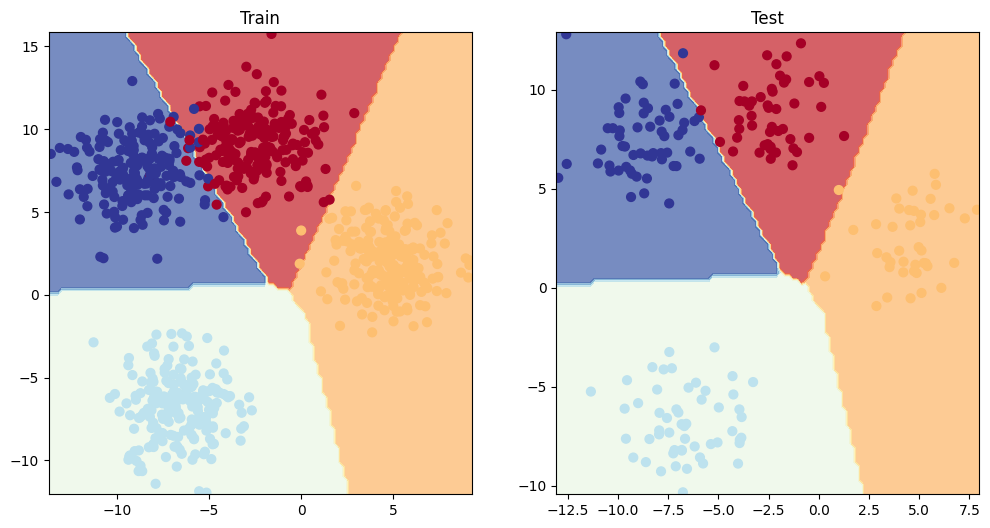

In [197]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [208]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 48.0 MB/s eta 0:00:00


In [211]:
from torchmetrics import Accuracy
# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(test_preds, y_test)

tensor(0.9900, device='cuda:0')